In [1]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 7.0 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip3 install mlflow

  Using cached GitPython-3.1.40-py3-none-any.whl.metadata (12 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 19.2 MB/s eta 0:00:00
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 31.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 4.2 MB/s eta 0:00:00
Using cached GitPython-3.1.40-py3-none-any.whl (190 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 22.4 MB/s eta 0:00:00
Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 17.7 MB/s eta 0:00:00
Using cached smmap-5.0.1-py3-none-any.whl (24 kB)


In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
pd.set_option('display.max_rows', 100)
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import datetime
import os
import pandas as pd

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
# load the training, validation and test data files

schema = 's3://'
bucket = 'ogunes-promise'
project = 'EDD'
key = 'ml_train_val_test_set/20231113_v4' # 20231113_v2

main_path = os.path.join(schema, bucket, project, key)

df_train_val = pd.read_parquet(os.path.join(main_path, 'train_val_2023-01-01_2023-06-01'))
df_test = pd.read_parquet(os.path.join(main_path, 'test_2023-06-01_2023-08-01'))

In [5]:
df_train_val.shape

(21510416, 72)

In [6]:
df_test.shape

(8390643, 72)

In [10]:
df_train_val.dtypes

order_id                                                                       object
shipment_tracking_number                                                       object
ffmcenter_name                                                                 object
fc_type                                                                        object
uom_flag                                                                        int32
carrier_code                                                                   object
customer_postcode                                                              object
customer_zip3                                                                  object
customer_state                                                                 object
shipment_delivery_date                                                         object
initial_shipment_delivery_attempt_date                                         object
shipment_shipped_date                                 

In [11]:
# Target column: to predict the number of shipment days
target = 'std_actual_vattempted'

In [28]:
feature_cols = list(df_train_val.columns)
feature_cols = [e for e in feature_cols 
                if e not in ['order_id', 'shipment_tracking_number', 'ffmcenter_name', 'fc_type', 
                             'customer_postcode', 'customer_zip3',
                             'shipment_delivery_date', 'initial_shipment_delivery_attempt_date',
                             'shipment_shipped_date',
                             'holiday_flag', 'shipped_fri_sat_tag', 'shipped_dow',
                             'std_v0', 'std_actual', 
                             'shipment_ship_route', 'shipment_ship_route_group',
                             'std_actual_vattempted', 'carrier_code', 'arc_range',
                             'routetype',
                             'routetype_CS',
                             'routetype_Direct',
                             'routetype_Others',
                             'routetype_Preload',
                             'routetype_RSF',
                             'ffmcenter_name_AVP1',
                             'ffmcenter_name_AVP2',
                             'ffmcenter_name_BNA1',
                             'ffmcenter_name_CFC1',
                             'ffmcenter_name_CLT1',
                             'ffmcenter_name_DAY1',
                             'ffmcenter_name_DFW1',
                             'ffmcenter_name_EFC3',
                             'ffmcenter_name_MCI1',
                             'ffmcenter_name_MCO1',
                             'ffmcenter_name_MDT1',
                             'ffmcenter_name_PHX1',
                             'ffmcenter_name_RNO1',
                             'ffmcenter_name_WFC2',
                             'fc_type_G1',
                             'fc_type_G2',
                             'holiday_flag_before_holiday',
                             'holiday_flag_holiday',
                             'holiday_flag_regular',
                             'shipped_fri_sat_tag_friday',
                             'shipped_fri_sat_tag_regular',
                             'shipped_fri_sat_tag_saturday',
                             'carrier_code_FDXGD',
                             'carrier_code_FDXHD',
                             'carrier_code_ONTRGD',
                             'warehouse_expected_weight'
                            ]]
feature_cols

['uom_flag',
 'customer_state',
 'is_after_cpt',
 'hours_till_cpt',
 'package_size',
 'adjtnt',
 'nextadjtnt',
 'distance_mi',
 'actual_zone',
 'avg_-28_-1_std_actual_vattempted_shipped_dow_shipment_ship_route',
 'avg_-7_-1_std_actual_vattempted_shipped_dow_shipment_ship_route',
 'avg_-28_-1_std_actual_vattempted_shipped_dow_actual_zone',
 'avg_-7_-1_std_actual_vattempted_shipped_dow_actual_zone',
 'avg_-28_-1_std_actual_vattempted_shipped_dow_ffmcenter_name_customer_state',
 'avg_-7_-1_std_actual_vattempted_shipped_dow_ffmcenter_name_customer_state',
 'shipped_dow_0',
 'shipped_dow_1',
 'shipped_dow_2',
 'shipped_dow_3',
 'shipped_dow_4',
 'shipped_dow_5',
 'shipped_dow_6']

In [29]:
# train
df_train_val_x = df_train_val[feature_cols + [target]]

# # Split the data into X and y
X_train_val = df_train_val_x.drop(target, axis=1)
y_train_val = df_train_val_x[target]

# test
df_test_x = df_test[feature_cols + [target]]

# # Split the data into X and y
X_test = df_test_x.drop(target, axis=1)
y_test = df_test_x[target]

In [30]:
X_train_val["customer_state"] = X_train_val["customer_state"].astype("category")
X_test["customer_state"] = X_test["customer_state"].astype("category")

In [10]:
"""
# Define the hyperparameter grid
param_grid = {
    'max_depth': [6, 7, 8],
    'learning_rate': [0.15, 0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.6, 0.65]
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             enable_categorical=True)

# Create the GridSearchCV object
model_x = GridSearchCV(xgb_model,
                       param_grid,
                       cv=3,
                       scoring='neg_mean_absolute_error',
                       verbose=2)

# Fit the GridSearchCV object to the training data
model_x.fit(X_train_val, y_train_val)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", model_x.best_params_)
print("Best score: ", model_x.best_score_)
"""

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=6, subsample=0.7; total time= 1.2min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=6, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=6, subsample=0.7; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=7, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=7, subsample=0.7; total time= 1.3min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=7, subsample=0.7; total time= 1.4min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.6, learning_rate=0.15, max_depth=8, subsample=0.7; total time= 1.5min
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_dep

In [11]:
"""
# Make predictions on training and validation datasets
y_train_val_pred = model_x.predict(X_train_val)
y_test_pred = model_x.predict(X_test)
"""

In [12]:
"""
accuracy = accuracy_score(y_train_val, np.round(y_train_val_pred))
print(f"Accuracy: {accuracy:.4f}")

accuracy = accuracy_score(y_test, np.round(y_test_pred))
print(f"Accuracy: {accuracy:.4f}")
"""

Accuracy: 0.8341
Accuracy: 0.8173


In [13]:
#eta=0.1,
#subsample=0.7,
#max_depth=8,
#colsample_bytree=0.6,

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             enable_categorical=True)

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'subsample': [0.7],
    'colsample_bytree': [0.6]
}

# Create the GridSearchCV object
model_xx = GridSearchCV(xgb_model,
                        param_grid,
                        cv=3,
                        scoring='neg_mean_absolute_error',
                        verbose=2)

# Fit the GridSearchCV object to the training data
model_xx.fit(X_train_val, y_train_val)

# Make predictions on training and validation datasets
y_train_val_pred = model_xx.predict(X_train_val)
y_test_pred = model_xx.predict(X_test)

accuracy = accuracy_score(y_train_val, np.round(y_train_val_pred))
print(f"Accuracy: {accuracy:.4f}")

accuracy = accuracy_score(y_test, np.round(y_test_pred))
print(f"Accuracy: {accuracy:.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, subsample=0.7; total time= 1.6min
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, subsample=0.7; total time= 1.6min
[CV] END colsample_bytree=0.6, learning_rate=0.1, max_depth=8, subsample=0.7; total time= 1.6min
Accuracy: 0.8281
Accuracy: 0.8230


In [24]:
# Regression
model_xxx = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    max_depth=8,
                    learning_rate=0.1,
                    subsample=0.7,
                    colsample_bytree=0.6,
                    enable_categorical=True)

model_xxx.fit(X_train_val, y_train_val)

# Make predictions on training and validation datasets
y_train_val_pred = model_xxx.predict(X_train_val)
y_test_pred = model_xxx.predict(X_test)

In [26]:
accuracy = accuracy_score(y_train_val, np.round(y_train_val_pred))
print(f"Accuracy: {accuracy:.4f}")

accuracy = accuracy_score(y_test, np.round(y_test_pred))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8281
Accuracy: 0.8230


In [27]:
# the value when some element of the y_true is zero is arbitrarily high because
# of the division by epsilon
mape = mean_absolute_percentage_error(y_train_val+0.01, y_train_val_pred+0.01)
print(f"MAPE: {mape:.4f}")

mape = mean_absolute_percentage_error(y_test+0.01, y_test_pred+0.01)
print(f"MAPE: {mape:.4f}")

MAPE: 1.2470
MAPE: 1.4594


In [80]:
xgb_fea_imp = pd.DataFrame(list(model_xxx.get_booster().get_fscore().items()),
                           columns=['feature','importance']).sort_values('importance', ascending=False)
print('', xgb_fea_imp)

                                               feature  importance
1                                      customer_state      3432.0
9   avg_-28_-1_std_actual_vattempted_shipped_dow_s...      3263.0
10  avg_-7_-1_std_actual_vattempted_shipped_dow_sh...      2466.0
13  avg_-28_-1_std_actual_vattempted_shipped_dow_f...      2081.0
3                                      hours_till_cpt      2007.0
12  avg_-7_-1_std_actual_vattempted_shipped_dow_ac...      1952.0
14  avg_-7_-1_std_actual_vattempted_shipped_dow_ff...      1753.0
11  avg_-28_-1_std_actual_vattempted_shipped_dow_a...      1722.0
7                                         distance_mi      1711.0
5                                              adjtnt       785.0
6                                          nextadjtnt       757.0
20                                      shipped_dow_5       542.0
8                                         actual_zone       451.0
21                                      shipped_dow_6       400.0
4        

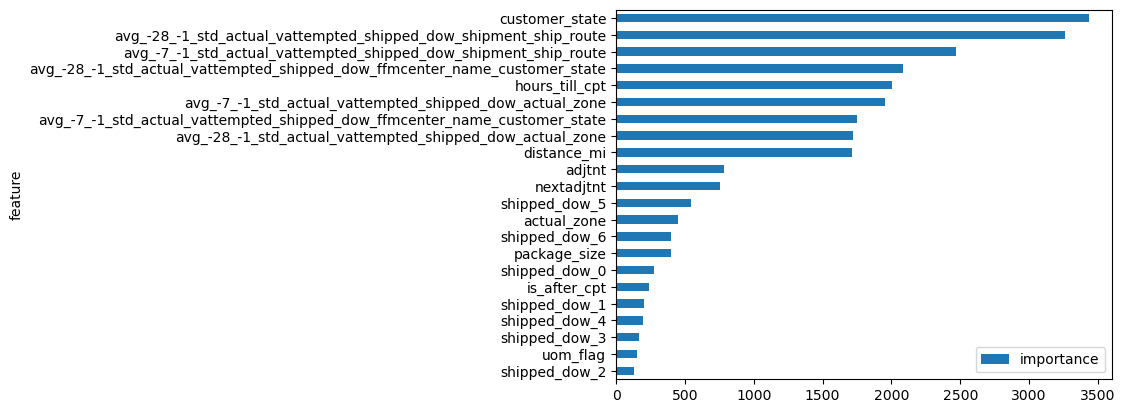

In [81]:
ax = xgb_fea_imp.sort_values('importance', ascending=True).plot.barh(x='feature', y='importance')

### Ensemble Model

In [31]:
ensemble_X_train_val = df_train_val[[
    'customer_state', 'distance_mi', 'std_v0',
    #'shipped_fri_sat_tag_friday', 'shipped_fri_sat_tag_regular', 'shipped_fri_sat_tag_saturday',
    #'holiday_flag_before_holiday', 'holiday_flag_holiday', 'holiday_flag_regular',
    'shipped_dow_0', 'shipped_dow_1', 'shipped_dow_2',
    'shipped_dow_3', 'shipped_dow_4', 'shipped_dow_5', 'shipped_dow_6',
    #'carrier_code_FDXGD', 'carrier_code_FDXHD', 'carrier_code_ONTRGD'
]].reset_index(drop=True)

ensemble_X_train_val['ml_model'] = np.round(y_train_val_pred)

ensemble_X_test = df_test[[
    'customer_state', 'distance_mi', 'std_v0',
    #'shipped_fri_sat_tag_friday', 'shipped_fri_sat_tag_regular', 'shipped_fri_sat_tag_saturday',
    #'holiday_flag_before_holiday', 'holiday_flag_holiday', 'holiday_flag_regular',
    'shipped_dow_0', 'shipped_dow_1', 'shipped_dow_2',
    'shipped_dow_3', 'shipped_dow_4', 'shipped_dow_5', 'shipped_dow_6',
    #'carrier_code_FDXGD', 'carrier_code_FDXHD', 'carrier_code_ONTRGD'
]].reset_index(drop=True)

ensemble_X_test['ml_model'] = np.round(y_test_pred)

In [32]:
ensemble_X_train_val["customer_state"] = ensemble_X_train_val["customer_state"].astype("category")
ensemble_X_test["customer_state"] = ensemble_X_test["customer_state"].astype("category")

In [33]:
ensemble_X_train_val.dtypes

customer_state    category
distance_mi        float64
std_v0               int32
shipped_dow_0        int32
shipped_dow_1        int32
shipped_dow_2        int32
shipped_dow_3        int32
shipped_dow_4        int32
shipped_dow_5        int32
shipped_dow_6        int32
ml_model           float32
dtype: object

In [57]:
# Regression
model_y = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    max_depth=15,
                    learning_rate=0.2,
                    subsample=0.7,
                    colsample_bytree=0.6,
                    enable_categorical=True)

model_y.fit(ensemble_X_train_val, y_train_val)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
# Make predictions on training and validation datasets
y_train_val_ensemble_pred = model_y.predict(ensemble_X_train_val)
y_test_ensemble_pred = model_y.predict(ensemble_X_test)

In [59]:
accuracy = accuracy_score(y_train_val, np.round(y_train_val_ensemble_pred))
print(f"Accuracy: {accuracy:.4f}")

accuracy = accuracy_score(y_test, np.round(y_test_ensemble_pred))
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8583
Accuracy: 0.8638


In [60]:
mape = mean_absolute_percentage_error(y_train_val+0.01, y_train_val_ensemble_pred+0.01)
print(f"MAPE: {mape:.4f}")

mape = mean_absolute_percentage_error(y_test+0.01, y_test_ensemble_pred+0.01)
print(f"MAPE: {mape:.4f}")

MAPE: 0.5765
MAPE: 0.5449


In [78]:
xgb_fea_imp = pd.DataFrame(list(model_y.get_booster().get_fscore().items()),
columns = ['feature','importance']).sort_values('importance', ascending=False)
print('', xgb_fea_imp)

            feature  importance
1      distance_mi    171078.0
0   customer_state     83519.0
2           std_v0     18631.0
10        ml_model     16808.0
7    shipped_dow_4     11089.0
6    shipped_dow_3      8796.0
5    shipped_dow_2      7382.0
4    shipped_dow_1      6634.0
3    shipped_dow_0      6181.0
9    shipped_dow_6      5103.0
8    shipped_dow_5      3051.0


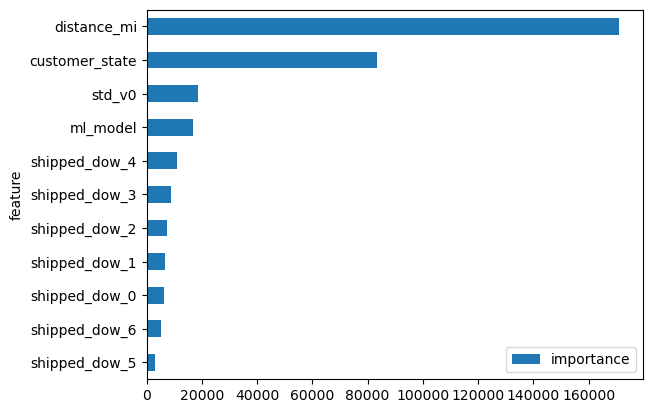

In [79]:
ax = xgb_fea_imp.sort_values('importance', ascending=True).plot.barh(x='feature', y='importance')

#### Preds to report

In [62]:
df_train_val['tag'] = 'train_val'
df_test['tag'] = 'test'


df_train_val['ensemble_pred'] = y_train_val_ensemble_pred
df_test['ensemble_pred'] = y_test_ensemble_pred

df_train_val['ensemble_pred_rounded'] = np.round(y_train_val_ensemble_pred)
df_test['ensemble_pred_rounded'] = np.round(y_test_ensemble_pred)


df_train_val['ml_pred'] = y_train_val_pred
df_test['ml_pred'] = y_test_pred

df_train_val['ml_pred_rounded'] = np.round(y_train_val_pred)
df_test['ml_pred_rounded'] = np.round(y_test_pred)

In [63]:
report_out = pd.concat([df_train_val, df_test], axis=0)

In [65]:
report_out.columns

Index(['order_id', 'shipment_tracking_number', 'ffmcenter_name', 'fc_type',
       'uom_flag', 'carrier_code', 'customer_postcode', 'customer_zip3',
       'customer_state', 'shipment_delivery_date',
       'initial_shipment_delivery_attempt_date', 'shipment_shipped_date',
       'holiday_flag', 'shipped_fri_sat_tag', 'shipped_dow', 'is_after_cpt',
       'hours_till_cpt', 'warehouse_expected_weight', 'package_size', 'adjtnt',
       'nextadjtnt', 'std_v0', 'shipment_ship_route', 'arc_range',
       'distance_mi', 'actual_zone', 'routetype',
       'avg_-28_-1_std_actual_vattempted_shipped_dow_shipment_ship_route',
       'avg_-7_-1_std_actual_vattempted_shipped_dow_shipment_ship_route',
       'avg_-28_-1_std_actual_vattempted_shipped_dow_actual_zone',
       'avg_-7_-1_std_actual_vattempted_shipped_dow_actual_zone',
       'avg_-28_-1_std_actual_vattempted_shipped_dow_ffmcenter_name_customer_state',
       'avg_-7_-1_std_actual_vattempted_shipped_dow_ffmcenter_name_customer_state',
 

In [66]:
report_out = report_out[['order_id', 'shipment_tracking_number', 'ffmcenter_name', 'fc_type',
                         'uom_flag', 'carrier_code', 'customer_postcode', 'customer_zip3',
                         'customer_state', 'shipment_delivery_date',
                         'initial_shipment_delivery_attempt_date', 'shipment_shipped_date', 'holiday_flag',
                         'shipped_fri_sat_tag', 'shipped_dow', 'is_after_cpt', 'hours_till_cpt',
                         'warehouse_expected_weight', 'package_size', 'adjtnt', 'nextadjtnt',
                         'std_v0', 'shipment_ship_route',
                         'arc_range', 'distance_mi',
                         'actual_zone', 'std_actual', 'std_actual_vattempted',
                         'tag', 'ensemble_pred', 'ensemble_pred_rounded', 'ml_pred', 'ml_pred_rounded',
                        'routetype']]

In [67]:
report_out.head()

,order_id,shipment_tracking_number,ffmcenter_name,fc_type,uom_flag,carrier_code,customer_postcode,customer_zip3,customer_state,shipment_delivery_date,...,distance_mi,actual_zone,std_actual,std_actual_vattempted,tag,ensemble_pred,ensemble_pred_rounded,ml_pred,ml_pred_rounded,routetype
0,1306828909,608347536980,DFW1,G1,0,FDXHD,78415,784,TX,2023-01-30,...,343.952,4,3,3,train_val,2.345700,2.0,2.425830,2.0,CS
1,1351324445,619904400635,AVP1,G1,0,FDXHD,10509,105,NY,2023-05-13,...,121.336,2,1,1,train_val,1.039473,1.0,1.031925,1.0,Preload
2,1317134235,635565337431,MCI1,G2,0,FDXHD,63123,631,MO,2023-02-21,...,227.599,3,1,1,train_val,1.011974,1.0,1.046484,1.0,Direct
3,1320601552,590930346580,EFC3,G1,0,FDXHD,28734,287,NC,2023-03-02,...,494.042,4,1,1,train_val,1.113795,1.0,1.375000,1.0,CS
4,1301477269,628817988775,MCO1,G1,0,FDXHD,32779,327,FL,2023-01-16,...,56.704,1,2,2,train_val,2.015039,2.0,1.739800,2.0,Preload


In [68]:
report_out.to_csv(os.path.join(schema, bucket, project, 'reporting/model_out/20231114.csv'), 
                  index=False,
                  header=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [69]:
report_out.shape

(29901059, 34)

In [70]:
report_out[['shipment_tracking_number']].drop_duplicates().shape

(29901059, 1)